# Female/Male train
We sperate our dataset into two; one for female and one for male
We then train on one gender and test on the other and vice cersa

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
import mrmr
import optuna
import torch
import gpytorch
import torchmetrics

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets_with_demographic.csv'))

df.head()

,TAU_bl,PTAU_bl,ABETA_bl,DX_bl,DX,AGE,PTGENDER,PTEDUCAT,PTRACCAT,MMSE_bl,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,4.617099,2.310553,731.8,3,2,67.5,0,16,1.0,30.0,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,5.783210,3.537766,780.3,3,2,71.8,1,15,0.0,28.0,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,6.195221,3.973682,832.7,0,0,78.0,1,12,0.0,24.0,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,4.683981,2.356126,590.4,3,2,64.9,0,16,0.0,29.0,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,5.509793,3.210037,466.1,3,2,75.1,1,18,0.0,30.0,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675


In [3]:
#

df['tau_ab_ratio'] = np.exp(df['TAU_bl']) / df['ABETA_bl']
df['ptau_ab_ratio'] =np.exp(df['PTAU_bl']) / df['ABETA_bl']

df['A+'] = df['ABETA_bl'].apply(lambda x: 1 if x < 880 else 0)
df['T+'] = df['ptau_ab_ratio'].apply(lambda x: 1 if x > 0.028 else 0)
df['N+'] = df['tau_ab_ratio'].apply(lambda x: 1 if x > 0.33 else 0)

df.head()

,TAU_bl,PTAU_bl,ABETA_bl,DX_bl,DX,AGE,PTGENDER,PTEDUCAT,PTRACCAT,MMSE_bl,...,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,tau_ab_ratio,ptau_ab_ratio,A+,T+,N+
0,4.617099,2.310553,731.8,3,2,67.5,0,16,1.0,30.0,...,0.011917,0.008881,0.006231,0.000712,0.000659,0.138289,0.013774,1,0,0
1,5.783210,3.537766,780.3,3,2,71.8,1,15,0.0,28.0,...,0.012666,0.008033,0.006029,0.000770,0.000699,0.416250,0.044073,1,1,1
2,6.195221,3.973682,832.7,0,0,78.0,1,12,0.0,24.0,...,0.012902,0.007799,0.005730,0.000804,0.000760,0.588928,0.063865,1,1,1
3,4.683981,2.356126,590.4,3,2,64.9,0,16,0.0,29.0,...,0.012782,0.009789,0.006613,0.000748,0.000675,0.183266,0.017869,1,0,0
4,5.509793,3.210037,466.1,3,2,75.1,1,18,0.0,30.0,...,0.012595,0.008533,0.005170,0.000675,0.000675,0.530144,0.053165,1,1,1


In [4]:
# mapping is {male: 0, female: 1}
# split into a female and male df

male_df = df[df['PTGENDER'] == 0]
female_df = df[df['PTGENDER'] == 1]

print(f"Male DF: {male_df.shape}")
print(f"Female DF: {female_df.shape}")

Male DF: (284, 193)
Female DF: (254, 193)


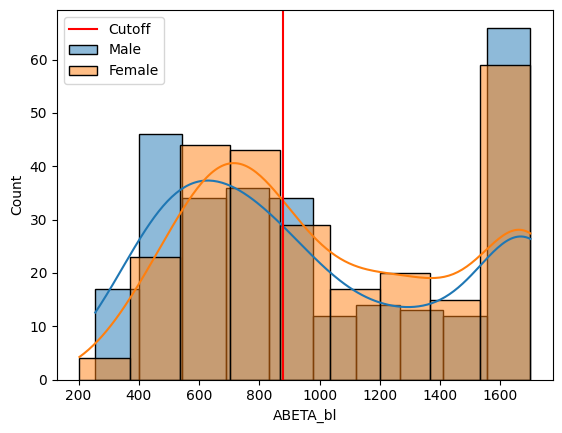

In [19]:
sns.histplot(male_df, x = 'ABETA_bl', kde=True, label = 'Male')
sns.histplot(female_df, x = 'ABETA_bl', kde =True, label = 'Female')
plt.axvline(880, 0,120,color='red', label= 'Cutoff')
plt.legend()
plt.show()

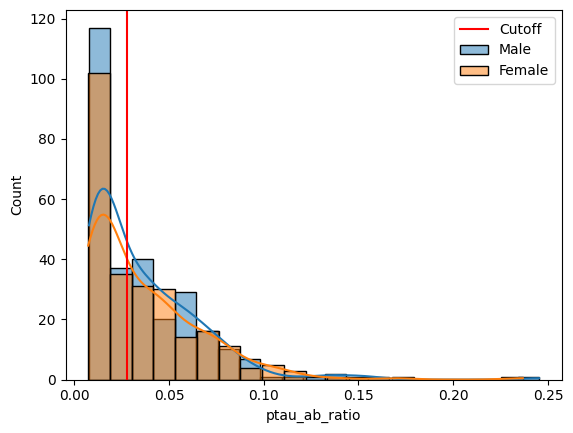

In [20]:
sns.histplot(male_df, x = 'ptau_ab_ratio', kde=True, label = 'Male')
sns.histplot(female_df, x = 'ptau_ab_ratio', kde =True, label = 'Female')
plt.axvline(0.028, 0,120,color='red', label = 'Cutoff')
plt.legend()
plt.show()

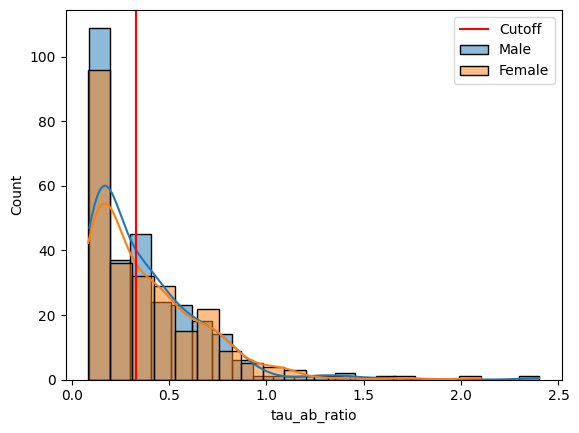

In [21]:
sns.histplot(male_df, x = 'tau_ab_ratio', kde=True, label = 'Male')
sns.histplot(female_df, x = 'tau_ab_ratio', kde =True, label = 'Female')
plt.axvline(0.33, 0,120,color='red', label='Cutoff')
plt.legend()
plt.show()

In [5]:
# drop all cols just to the suvrs and targets

male_df_dropped = male_df.drop(columns=['DX_bl','DX','AGE','PTGENDER','PTRACCAT','FHQMOM','FHQMOMAD','FHQDAD','FHQDADAD','RAVLT_perc_forgetting_bl','PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl','tau_ab_ratio',	'ptau_ab_ratio'])
male_df_dropped.head()


female_df_dropped = female_df.drop(columns=['DX_bl','DX','AGE','PTGENDER','PTRACCAT','FHQMOM','FHQMOMAD','FHQDAD','FHQDADAD','RAVLT_perc_forgetting_bl','PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl','tau_ab_ratio',	'ptau_ab_ratio'])
female_df_dropped.head()

,SUVr_ACC_pre_L.nii,SUVr_ACC_pre_R.nii,SUVr_ACC_sub_L.nii,SUVr_ACC_sub_R.nii,SUVr_ACC_sup_L.nii,SUVr_ACC_sup_R.nii,SUVr_Amygdala_L.nii,SUVr_Amygdala_R.nii,SUVr_Angular_L.nii,SUVr_Angular_R.nii,...,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,A+,T+,N+
1,1.190475,1.118614,1.144220,0.928409,0.057261,0.053242,0.013008,0.017184,1.740331,2.026532,...,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699,1,1,1
2,1.481382,1.476620,1.518520,1.375084,0.054272,0.053113,0.013620,0.016730,1.590446,1.179038,...,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760,1,1,1
4,-0.174385,-0.456932,-0.096572,-0.210932,0.042674,0.039067,0.011457,0.013684,-0.166624,-0.560099,...,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675,1,1,1
5,1.285751,1.554366,1.210701,1.011784,0.057293,0.058095,0.012772,0.015369,2.218193,2.143749,...,0.022286,0.010830,0.013725,0.009463,0.007096,0.000792,0.000668,1,1,1
6,-0.945954,-0.779468,-0.622167,-0.730309,0.037928,0.036649,0.009892,0.012481,-1.020075,-0.809548,...,0.017347,0.008983,0.011397,0.008255,0.006385,0.000766,0.000668,0,0,0


In [6]:
print(male_df_dropped.shape)
print(female_df_dropped.shape)

(284, 169)
(254, 169)


In [7]:
class SVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super().__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()
        
    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

In [10]:
print("===============================================================================================")
print("A+ prediction from Male training")
print("===============================================================================================")
print("\n")

rs = np.random.randint(0,75)

print(f"Random_state: {rs}\n")
# train test split for A+
m_X = male_df_dropped.drop(columns=['A+', 'T+', 'N+'])
m_y = male_df_dropped['A+']

m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(m_X, m_y, train_size=0.8, random_state=rs)

f_X = female_df_dropped.drop(columns=['A+', 'T+', 'N+'])
f_y = female_df_dropped['A+']

f_X_train, f_X_test, f_y_train, f_y_test = train_test_split(f_X, f_y, train_size=0.8, random_state=rs)

# Train on male test on female
scaler = StandardScaler()
m_X_train = scaler.fit_transform(m_X_train)
m_X_test = scaler.transform(m_X_test)
f_X_test = scaler.fit_transform(f_X_test)
f_X_train = scaler.transform(f_X_train)

# Convert to PyTorch tensors
m_X_train = torch.tensor(m_X_train, dtype=torch.float32).to(device)
m_X_test = torch.tensor(m_X_test, dtype=torch.float32).to(device)
f_X_train = torch.tensor(f_X_train, dtype=torch.float32).to(device)
f_X_test = torch.tensor(f_X_test, dtype=torch.float32).to(device)
m_y_train = torch.tensor(m_y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
m_y_test = torch.tensor(m_y_test.values, dtype=torch.float32).to(device).unsqueeze(1)
f_y_test = torch.tensor(f_y_test.values, dtype=torch.float32).to(device).unsqueeze(1)
f_y_train = torch.tensor(f_y_train.values, dtype=torch.float32).to(device).unsqueeze(1)



model = SVM(m_X_train, m_y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

# train the model on male X train
epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(m_X_train)
    loss = bhl(output, m_y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()

# test on male train
model.eval()
with torch.no_grad():
    y_pred = model(m_X_train)
    y_pred_proba = y_pred.cpu().numpy()
    y_pred = (y_pred > 0.5).float()
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = m_y_train.cpu().numpy()
    print("Male Train Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Male Train Precision:", precision_score(y_train_np, y_pred_np))
    print("Male Train Recall:", recall_score(y_train_np, y_pred_np))
    print("Male Train F1 Score:", 2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))
    print("Male Train AUROC:", roc_auc_score(y_train_np, y_pred_proba))
    print("\n")

# test on male test
model.eval()
with torch.no_grad():
    y_test_pred = model(m_X_test)
    y_test_pred_proba = y_test_pred.cpu().numpy()
    y_test_pred = (y_test_pred > 0.5).float()
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = m_y_test.cpu().numpy()
    print("Male Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Male Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Male Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Male Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print("Male Test AUROC:", roc_auc_score(y_test_np, y_test_pred_proba))
    num_misclassified_male = (y_test_pred_np != y_test_np).sum()
    print("Number of Misclassifications (Male Test):", num_misclassified_male)
    print("\n")

# test on female test
model.eval()
with torch.no_grad():
    y_test_pred = model(f_X_test)
    y_test_pred_proba = y_test_pred.cpu().numpy()
    y_test_pred = (y_test_pred > 0.5).float()
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = f_y_test.cpu().numpy()
    print("Female Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Female Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Female Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Female Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print("Female Test AUROC:", roc_auc_score(y_test_np, y_test_pred_proba))
    num_misclassified_female = (y_test_pred_np != y_test_np).sum()
    print("Number of Misclassifications (Female Test):", num_misclassified_female)
    print("\n")

A+ prediction from Male training


Random_state: 49

Male Train Accuracy: 0.8458149779735683
Male Train Precision: 0.897196261682243
Male Train Recall: 0.8
Male Train F1 Score: 0.8458149779735684
Male Train AUROC: 0.8824376947040498


Male Test Accuracy: 0.7543859649122807
Male Test Precision: 0.7916666666666666
Male Test Recall: 0.6785714285714286
Male Test F1 Score: 0.7307692307692307
Male Test AUROC: 0.8312807881773399
Number of Misclassifications (Male Test): 14


Female Test Accuracy: 0.8823529411764706
Female Test Precision: 0.9166666666666666
Female Test Recall: 0.8461538461538461
Female Test F1 Score: 0.8799999999999999
Female Test AUROC: 0.9084615384615384
Number of Misclassifications (Female Test): 6




In [14]:
print("===============================================================================================")
print("A+ prediction from Female training")
print("===============================================================================================")
print("\n")

rs = np.random.randint(0,75)

print(f"Random_state: {rs}\n")

# train test split for A+
m_X = male_df_dropped.drop(columns=['A+', 'T+', 'N+'])
m_y = male_df_dropped['A+']

m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(m_X, m_y, train_size=0.8, random_state=rs)

f_X = female_df_dropped.drop(columns=['A+', 'T+', 'N+'])
f_y = female_df_dropped['A+']

f_X_train, f_X_test, f_y_train, f_y_test = train_test_split(f_X, f_y, train_size=0.8, random_state=rs)

# Train on female test on male
scaler = StandardScaler()
f_X_train = scaler.fit_transform(f_X_train)
m_X_test = scaler.transform(m_X_test)
f_X_test = scaler.fit_transform(f_X_test)
m_X_train = scaler.transform(m_X_train)


# Convert to PyTorch tensors
m_X_train = torch.tensor(m_X_train, dtype=torch.float32).to(device)
m_X_test = torch.tensor(m_X_test, dtype=torch.float32).to(device)
f_X_train = torch.tensor(f_X_train, dtype=torch.float32).to(device)
f_X_test = torch.tensor(f_X_test, dtype=torch.float32).to(device)
m_y_train = torch.tensor(m_y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
m_y_test = torch.tensor(m_y_test.values, dtype=torch.float32).to(device).unsqueeze(1)
f_y_test = torch.tensor(f_y_test.values, dtype=torch.float32).to(device).unsqueeze(1)
f_y_train = torch.tensor(f_y_train.values, dtype=torch.float32).to(device).unsqueeze(1)



model = SVM(f_X_train, f_y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

# train the model on female train
epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(f_X_train)
    loss = bhl(output, f_y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()

# test on female train
model.eval()
with torch.no_grad():
    y_pred = model(f_X_train)
    y_pred_proba = y_pred.cpu().numpy()
    y_pred = (y_pred > 0.5).float()
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = f_y_train.cpu().numpy()
    print("Female Train Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Female Train Precision:", precision_score(y_train_np, y_pred_np))
    print("Female Train Recall:", recall_score(y_train_np, y_pred_np))
    print("Female Train F1 Score:", 2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))
    print("Female Train AUROC:", roc_auc_score(y_train_np, y_pred_proba))
    print("\n")

# test on female test
model.eval()
with torch.no_grad():
    y_test_pred = model(f_X_test)
    y_test_pred_proba = y_test_pred.cpu().numpy()
    y_test_pred = (y_test_pred > 0.5).float()
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = f_y_test.cpu().numpy()
    print("Female Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Female Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Female Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Female Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print("Female Test AUROC:", roc_auc_score(y_test_np, y_test_pred_proba))
    num_misclassified_female = (y_test_pred_np != y_test_np).sum()
    print("Number of Misclassifications (Female Test):", num_misclassified_female)
    print("\n")

# test on male test
model.eval()
with torch.no_grad():
    y_test_pred = model(m_X_test)
    y_test_pred_proba = y_test_pred.cpu().numpy()
    y_test_pred = (y_test_pred > 0.5).float()
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = m_y_test.cpu().numpy()
    print("Male Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Male Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Male Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Male Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print("Male Test AUROC:", roc_auc_score(y_test_np, y_test_pred_proba))
    num_misclassified_male = (y_test_pred_np != y_test_np).sum()
    print("Number of Misclassifications (Male Test):", num_misclassified_male)
    print("\n")

A+ prediction from Female training


Random_state: 27

Female Train Accuracy: 0.8325123152709359
Female Train Precision: 0.7755102040816326
Female Train Recall: 0.8636363636363636
Female Train F1 Score: 0.8172043010752688
Female Train AUROC: 0.8817687747035574


Female Test Accuracy: 0.8823529411764706
Female Test Precision: 0.9285714285714286
Female Test Recall: 0.8666666666666667
Female Test F1 Score: 0.896551724137931
Female Test AUROC: 0.9682539682539683
Number of Misclassifications (Female Test): 6


Male Test Accuracy: 0.8421052631578947
Male Test Precision: 0.8461538461538461
Male Test Recall: 0.8148148148148148
Male Test F1 Score: 0.830188679245283
Male Test AUROC: 0.9123456790123456
Number of Misclassifications (Male Test): 9




In [18]:
print("===============================================================================================")
print("T+ prediction from Male training")
print("===============================================================================================")
print("\n")

rs = np.random.randint(0,75)

print(f"Random_state: {rs}\n")

# train test split for T+
m_X = male_df_dropped.drop(columns=['A+', 'T+', 'N+'])
m_y = male_df_dropped['T+']

m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(m_X, m_y, train_size=0.8, random_state=rs)

f_X = female_df_dropped.drop(columns=['A+', 'T+', 'N+'])
f_y = female_df_dropped['T+']

f_X_train, f_X_test, f_y_train, f_y_test = train_test_split(f_X, f_y, train_size=0.8, random_state=rs)

# Train on male test on female
scaler = StandardScaler()
m_X_train = scaler.fit_transform(m_X_train)
m_X_test = scaler.transform(m_X_test)
f_X_test = scaler.fit_transform(f_X_test)
f_X_train = scaler.transform(f_X_train)

# Convert to PyTorch tensors
m_X_train = torch.tensor(m_X_train, dtype=torch.float32).to(device)
m_X_test = torch.tensor(m_X_test, dtype=torch.float32).to(device)
f_X_train = torch.tensor(f_X_train, dtype=torch.float32).to(device)
f_X_test = torch.tensor(f_X_test, dtype=torch.float32).to(device)
m_y_train = torch.tensor(m_y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
m_y_test = torch.tensor(m_y_test.values, dtype=torch.float32).to(device).unsqueeze(1)
f_y_test = torch.tensor(f_y_test.values, dtype=torch.float32).to(device).unsqueeze(1)
f_y_train = torch.tensor(f_y_train.values, dtype=torch.float32).to(device).unsqueeze(1)

model = SVM(m_X_train, m_y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

# train the model on male X train
epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(m_X_train)
    loss = bhl(output, m_y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()

# test on male train
model.eval()
with torch.no_grad():
    y_pred = model(m_X_train)
    y_pred_proba = y_pred.cpu().numpy()
    y_pred = (y_pred > 0.5).float()
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = m_y_train.cpu().numpy()
    print("Male Train Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Male Train Precision:", precision_score(y_train_np, y_pred_np))
    print("Male Train Recall:", recall_score(y_train_np, y_pred_np))
    print("Male Train F1 Score:", 2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))
    print("Male Train AUROC:", roc_auc_score(y_train_np, y_pred_proba))
    print("\n")

# test on male test
model.eval()
with torch.no_grad():
    y_test_pred = model(m_X_test)
    y_test_pred_proba = y_test_pred.cpu().numpy()
    y_test_pred = (y_test_pred > 0.5).float()
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = m_y_test.cpu().numpy()
    print("Male Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Male Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Male Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Male Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print("Male Test AUROC:", roc_auc_score(y_test_np, y_test_pred_proba))
    num_misclassified_male = (y_test_pred_np != y_test_np).sum()
    print("Number of Misclassifications (Male Test):", num_misclassified_male)
    print("\n")

# test on female test
model.eval()
with torch.no_grad():
    y_test_pred = model(f_X_test)
    y_test_pred_proba = y_test_pred.cpu().numpy()
    y_test_pred = (y_test_pred > 0.5).float()
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = f_y_test.cpu().numpy()
    print("Female Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Female Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Female Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Female Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print("Female Test AUROC:", roc_auc_score(y_test_np, y_test_pred_proba))
    num_misclassified_male = (y_test_pred_np != y_test_np).sum()
    print("Number of Misclassifications (Female Test):", num_misclassified_male)
    print("\n")

T+ prediction from Male training


Random_state: 22

Male Train Accuracy: 0.8986784140969163
Male Train Precision: 0.9313725490196079
Male Train Recall: 0.8558558558558559
Male Train F1 Score: 0.892018779342723
Male Train AUROC: 0.9509940975458218


Male Test Accuracy: 0.8771929824561403
Male Test Precision: 0.9166666666666666
Male Test Recall: 0.8148148148148148
Male Test F1 Score: 0.8627450980392156
Male Test AUROC: 0.9172839506172838
Number of Misclassifications (Male Test): 7


Female Test Accuracy: 0.8627450980392157
Female Test Precision: 0.9259259259259259
Female Test Recall: 0.8333333333333334
Female Test F1 Score: 0.8771929824561403
Female Test AUROC: 0.9063492063492063
Number of Misclassifications (Female Test): 7




In [21]:
print("===============================================================================================")
print("T+ prediction from Female training")
print("===============================================================================================")
print("\n")

rs = np.random.randint(0,75)

print(f"Random_state: {rs}\n")

# train test split for A+
m_X = male_df_dropped.drop(columns=['A+', 'T+', 'N+'])
m_y = male_df_dropped['T+']

m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(m_X, m_y, train_size=0.8, random_state=rs)

f_X = female_df_dropped.drop(columns=['A+', 'T+', 'N+'])
f_y = female_df_dropped['T+']

f_X_train, f_X_test, f_y_train, f_y_test = train_test_split(f_X, f_y, train_size=0.8, random_state=rs)

# Train on female test on male
scaler = StandardScaler()
f_X_train = scaler.fit_transform(f_X_train)
m_X_test = scaler.transform(m_X_test)
f_X_test = scaler.fit_transform(f_X_test)
m_X_train = scaler.transform(m_X_train)

# Convert to PyTorch tensors
m_X_train = torch.tensor(m_X_train, dtype=torch.float32).to(device)
m_X_test = torch.tensor(m_X_test, dtype=torch.float32).to(device)
f_X_train = torch.tensor(f_X_train, dtype=torch.float32).to(device)
f_X_test = torch.tensor(f_X_test, dtype=torch.float32).to(device)
m_y_train = torch.tensor(m_y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
m_y_test = torch.tensor(m_y_test.values, dtype=torch.float32).to(device).unsqueeze(1)
f_y_test = torch.tensor(f_y_test.values, dtype=torch.float32).to(device).unsqueeze(1)
f_y_train = torch.tensor(f_y_train.values, dtype=torch.float32).to(device).unsqueeze(1)

model = SVM(f_X_train, f_y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

# train the model on female train
epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(f_X_train)
    loss = bhl(output, f_y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()

# test on female train
model.eval()
with torch.no_grad():
    y_pred = model(f_X_train)
    y_pred_proba = y_pred.cpu().numpy()
    y_pred = (y_pred > 0.5).float()
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = f_y_train.cpu().numpy()
    print("Female Train Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Female Train Precision:", precision_score(y_train_np, y_pred_np))
    print("Female Train Recall:", recall_score(y_train_np, y_pred_np))
    print("Female Train F1 Score:", 2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))
    print("Female Train AUROC:", roc_auc_score(y_train_np, y_pred_proba))
    print("\n")

# test on female test
model.eval()
with torch.no_grad():
    y_test_pred = model(f_X_test)
    y_test_pred_proba = y_test_pred.cpu().numpy()
    y_test_pred = (y_test_pred > 0.5).float()
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = f_y_test.cpu().numpy()
    print("Female Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Female Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Female Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Female Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print("Female Test AUROC:", roc_auc_score(y_test_np, y_test_pred_proba))
    num_misclassified_male = (y_test_pred_np != y_test_np).sum()
    print("Number of Misclassifications (Female Test):", num_misclassified_male)
    print("\n")

# test on male test
model.eval()
with torch.no_grad():
    y_test_pred = model(m_X_test)
    y_test_pred_proba = y_test_pred.cpu().numpy()
    y_test_pred = (y_test_pred > 0.5).float()
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = m_y_test.cpu().numpy()
    print("Male Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Male Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Male Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Male Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print("Male Test AUROC:", roc_auc_score(y_test_np, y_test_pred_proba))
    num_misclassified_male = (y_test_pred_np != y_test_np).sum()
    print("Number of Misclassifications (Male Test):", num_misclassified_male)
    print("\n")

T+ prediction from Female training


Random_state: 41

Female Train Accuracy: 0.8866995073891626
Female Train Precision: 0.8936170212765957
Female Train Recall: 0.865979381443299
Female Train F1 Score: 0.8795811518324608
Female Train AUROC: 0.9358587823380665


Female Test Accuracy: 0.8235294117647058
Female Test Precision: 0.8
Female Test Recall: 0.8333333333333334
Female Test F1 Score: 0.816326530612245
Female Test AUROC: 0.9120370370370371
Number of Misclassifications (Female Test): 9


Male Test Accuracy: 0.8596491228070176
Male Test Precision: 0.9473684210526315
Male Test Recall: 0.72
Male Test F1 Score: 0.8181818181818181
Male Test AUROC: 0.8975000000000001
Number of Misclassifications (Male Test): 8




In [24]:
print("===============================================================================================")
print("N+ prediction from Male training")
print("===============================================================================================")
print("\n")

rs = np.random.randint(0,75)

print(f"Random_state: {rs}\n")

# train test split for A+
m_X = male_df_dropped.drop(columns=['A+', 'T+', 'N+'])
m_y = male_df_dropped['N+']

m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(m_X, m_y, train_size=0.8, random_state=rs)

f_X = female_df_dropped.drop(columns=['A+', 'T+', 'N+'])
f_y = female_df_dropped['N+']

f_X_train, f_X_test, f_y_train, f_y_test = train_test_split(f_X, f_y, train_size=0.8, random_state=rs)

# Train on male test on female
scaler = StandardScaler()
m_X_train = scaler.fit_transform(m_X_train)
m_X_test = scaler.transform(m_X_test)
f_X_test = scaler.fit_transform(f_X_test)
f_X_train = scaler.transform(f_X_train)

# Convert to PyTorch tensors
m_X_train = torch.tensor(m_X_train, dtype=torch.float32).to(device)
m_X_test = torch.tensor(m_X_test, dtype=torch.float32).to(device)
f_X_train = torch.tensor(f_X_train, dtype=torch.float32).to(device)
f_X_test = torch.tensor(f_X_test, dtype=torch.float32).to(device)
m_y_train = torch.tensor(m_y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
m_y_test = torch.tensor(m_y_test.values, dtype=torch.float32).to(device).unsqueeze(1)
f_y_test = torch.tensor(f_y_test.values, dtype=torch.float32).to(device).unsqueeze(1)
f_y_train = torch.tensor(f_y_train.values, dtype=torch.float32).to(device).unsqueeze(1)

model = SVM(m_X_train, m_y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

# train the model on male X train
epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(m_X_train)
    loss = bhl(output, m_y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()

# test on male train
model.eval()
with torch.no_grad():
    y_pred = model(m_X_train)
    y_pred_proba = y_pred.cpu().numpy()
    y_pred = (y_pred > 0.5).float()
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = m_y_train.cpu().numpy()
    print("Male Train Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Male Train Precision:", precision_score(y_train_np, y_pred_np))
    print("Male Train Recall:", recall_score(y_train_np, y_pred_np))
    print("Male Train F1 Score:", 2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))
    print("Male Train AUROC:", roc_auc_score(y_train_np, y_pred_proba))
    print("\n")

# test on male test
model.eval()
with torch.no_grad():
    y_test_pred = model(m_X_test)
    y_test_pred_proba = y_test_pred.cpu().numpy()
    y_test_pred = (y_test_pred > 0.5).float()
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = m_y_test.cpu().numpy()
    print("Male Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Male Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Male Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Male Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print("Male Test AUROC:", roc_auc_score(y_test_np, y_test_pred_proba))
    num_misclassified_male = (y_test_pred_np != y_test_np).sum()
    print("Number of Misclassifications (Male Test):", num_misclassified_male)
    print("\n")

# test on female test
model.eval()
with torch.no_grad():
    y_test_pred = model(f_X_test)
    y_test_pred_proba = y_test_pred.cpu().numpy()
    y_test_pred = (y_test_pred > 0.5).float()
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = f_y_test.cpu().numpy()
    print("Female Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Female Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Female Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Female Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print("Female Test AUROC:", roc_auc_score(y_test_np, y_test_pred_proba))
    num_misclassified_male = (y_test_pred_np != y_test_np).sum()
    print("Number of Misclassifications (Female Test):", num_misclassified_male)
    print("\n")

N+ prediction from Male training


Random_state: 57

Male Train Accuracy: 0.933920704845815
Male Train Precision: 0.9411764705882353
Male Train Recall: 0.9142857142857143
Male Train F1 Score: 0.9275362318840579
Male Train AUROC: 0.9539032006245121


Male Test Accuracy: 0.7719298245614035
Male Test Precision: 0.782608695652174
Male Test Recall: 0.6923076923076923
Male Test F1 Score: 0.7346938775510203
Male Test AUROC: 0.8933002481389579
Number of Misclassifications (Male Test): 13


Female Test Accuracy: 0.8823529411764706
Female Test Precision: 0.88
Female Test Recall: 0.88
Female Test F1 Score: 0.88
Female Test AUROC: 0.9446153846153846
Number of Misclassifications (Female Test): 6




In [27]:
print("===============================================================================================")
print("N+ prediction from Female training")
print("===============================================================================================")
print("\n")

rs = np.random.randint(0,75)

print(f"Random_state: {rs}\n")


# train test split for A+
m_X = male_df_dropped.drop(columns=['A+', 'T+', 'N+'])
m_y = male_df_dropped['N+']

m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(m_X, m_y, train_size=0.8, random_state=rs)

f_X = female_df_dropped.drop(columns=['A+', 'T+', 'N+'])
f_y = female_df_dropped['N+']

f_X_train, f_X_test, f_y_train, f_y_test = train_test_split(f_X, f_y, train_size=0.8, random_state=rs)

# Train on female test on male
scaler = StandardScaler()
f_X_train = scaler.fit_transform(f_X_train)
m_X_test = scaler.transform(m_X_test)
f_X_test = scaler.fit_transform(f_X_test)
m_X_train = scaler.transform(m_X_train)

# Convert to PyTorch tensors
m_X_train = torch.tensor(m_X_train, dtype=torch.float32).to(device)
m_X_test = torch.tensor(m_X_test, dtype=torch.float32).to(device)
f_X_train = torch.tensor(f_X_train, dtype=torch.float32).to(device)
f_X_test = torch.tensor(f_X_test, dtype=torch.float32).to(device)
m_y_train = torch.tensor(m_y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
m_y_test = torch.tensor(m_y_test.values, dtype=torch.float32).to(device).unsqueeze(1)
f_y_test = torch.tensor(f_y_test.values, dtype=torch.float32).to(device).unsqueeze(1)
f_y_train = torch.tensor(f_y_train.values, dtype=torch.float32).to(device).unsqueeze(1)

model = SVM(f_X_train, f_y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

# train the model on female train
epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(f_X_train)
    loss = bhl(output, f_y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()

# test on female train
model.eval()
with torch.no_grad():
    y_pred = model(f_X_train)
    y_pred_proba = y_pred.cpu().numpy()
    y_pred = (y_pred > 0.5).float()
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = f_y_train.cpu().numpy()
    print("Female Train Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Female Train Precision:", precision_score(y_train_np, y_pred_np))
    print("Female Train Recall:", recall_score(y_train_np, y_pred_np))
    print("Female Train F1 Score:", 2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))
    print("Female Train AUROC:", roc_auc_score(y_train_np, y_pred_proba))
    print("\n")

# test on female test
model.eval()
with torch.no_grad():
    y_test_pred = model(f_X_test)
    y_test_pred_proba = y_test_pred.cpu().numpy()
    y_test_pred = (y_test_pred > 0.5).float()
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = f_y_test.cpu().numpy()
    print("Female Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Female Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Female Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Female Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print("Female Test AUROC:", roc_auc_score(y_test_np, y_test_pred_proba))
    num_misclassified_male = (y_test_pred_np != y_test_np).sum()
    print("Number of Misclassifications (Female Test):", num_misclassified_male)
    print("\n")

# test on male test
model.eval()
with torch.no_grad():
    y_test_pred = model(m_X_test)
    y_test_pred_proba = y_test_pred.cpu().numpy()
    y_test_pred = (y_test_pred > 0.5).float()
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = m_y_test.cpu().numpy()
    print("Male Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Male Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Male Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Male Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print("Male Test AUROC:", roc_auc_score(y_test_np, y_test_pred_proba))
    num_misclassified_male = (y_test_pred_np != y_test_np).sum()
    print("Number of Misclassifications (Male Test):", num_misclassified_male)
    print("\n")

N+ prediction from Female training


Random_state: 41

Female Train Accuracy: 0.9261083743842364
Female Train Precision: 0.925531914893617
Female Train Recall: 0.9157894736842105
Female Train F1 Score: 0.9206349206349206
Female Train AUROC: 0.9455165692007796


Female Test Accuracy: 0.8431372549019608
Female Test Precision: 0.7777777777777778
Female Test Recall: 0.9130434782608695
Female Test F1 Score: 0.84
Female Test AUROC: 0.968944099378882
Number of Misclassifications (Female Test): 8


Male Test Accuracy: 0.8947368421052632
Male Test Precision: 0.84
Male Test Recall: 0.9130434782608695
Male Test F1 Score: 0.8749999999999999
Male Test AUROC: 0.918158567774936
Number of Misclassifications (Male Test): 6


